In [1]:
# Imports and Loads
import pandas as pd
import numpy as np
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns   # optional for nicer plots
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix


In [5]:
# Import The Data
import pandas as pd

file_path = r"C:\Users\sagni\Downloads\corporateCreditRatingWithFinancialRatios.xlsx"

df = pd.read_excel(file_path, sheet_name=0)

print("Loaded:", df.shape)
print(df.columns.tolist())


Loaded: (7805, 25)
['Rating Agency', 'Corporation', 'Rating', 'Rating Date', 'CIK', 'Binary Rating', 'SIC Code', 'Sector', 'Ticker', 'Current Ratio', 'Long-term Debt / Capital', 'Debt/Equity Ratio', 'Gross Margin', 'Operating Margin', 'EBIT Margin', 'EBITDA Margin', 'Pre-Tax Profit Margin', 'Net Profit Margin', 'Asset Turnover', 'ROE - Return On Equity', 'Return On Tangible Equity', 'ROA - Return On Assets', 'ROI - Return On Investment', 'Operating Cash Flow Per Share', 'Free Cash Flow Per Share']


In [7]:
# Exploring the data 
df.head()        # preview first 5 rows
df.info()        # check column types (especially 'Rating Date')
df['Rating'].unique()   # see the different credit rating categories


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7805 entries, 0 to 7804
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Rating Agency                  7805 non-null   object        
 1   Corporation                    7805 non-null   object        
 2   Rating                         7805 non-null   object        
 3   Rating Date                    7805 non-null   datetime64[ns]
 4   CIK                            7805 non-null   int64         
 5   Binary Rating                  7805 non-null   int64         
 6   SIC Code                       7805 non-null   int64         
 7   Sector                         7805 non-null   object        
 8   Ticker                         7805 non-null   object        
 9   Current Ratio                  7805 non-null   float64       
 10  Long-term Debt / Capital       7805 non-null   float64       
 11  Debt/Equity Ratio

array(['A-', 'AAA', 'BBB-', 'AA-', 'A', 'BBB+', 'BBB', 'BB', 'B', 'BB+',
       'B+', 'BB-', 'B-', 'A+', 'CCC', 'AA', 'CCC+', 'CC', 'C', 'CCC-',
       'AA+', 'D', 'CC+'], dtype=object)

In [9]:
#Step A — load & clean (firm id, year-end rating)
import pandas as pd
import numpy as np

file_path = r"C:\Users\sagni\Downloads\corporateCreditRatingWithFinancialRatios.xlsx"
df = pd.read_excel(file_path, sheet_name=0)

# standardize
df['Rating Date'] = pd.to_datetime(df['Rating Date'], errors='coerce')
df['Year'] = df['Rating Date'].dt.year
df['firm_id'] = df['CIK'].astype(str)  # CIK exists and is stable

# keep last rating in each calendar year (year-end snapshot)
df = df.sort_values(['firm_id','Rating Date'])
year_end = df.groupby(['firm_id','Year']).last().reset_index()[['firm_id','Year','Rating']]


In [7]:
import pandas as pd
import numpy as np

# Load the dataset again if needed
file_path = r"C:\Users\sagni\Downloads\corporateCreditRatingWithFinancialRatios.xlsx"
df = pd.read_excel(file_path, sheet_name=0)

# Step A — Data Preparation
df['Rating Date'] = pd.to_datetime(df['Rating Date'], errors='coerce')
df['Year'] = df['Rating Date'].dt.year
df['firm_id'] = df['CIK'].astype(str)

df = df.sort_values(['firm_id','Rating Date'])
year_end = df.groupby(['firm_id','Year']).last().reset_index()[['firm_id','Year','Rating']]


In [11]:
#Step B — create 1-year transitions (counts → P)
year_end['next_year'] = year_end['Year'] + 1
merged = pd.merge(year_end, year_end,
                  left_on=['firm_id','next_year'], right_on=['firm_id','Year'],
                  suffixes=('_t','_t1'))

counts = merged.groupby(['Rating_t','Rating_t1']).size().unstack(fill_value=0)

# set canonical rating order if you want specific ordering
ratings = sorted(list(set(year_end['Rating'])))
if 'D' in ratings:  # or 'Default' depending on label
    ratings = [r for r in ratings if r != 'D'] + ['D']

counts = counts.reindex(index=ratings, columns=ratings, fill_value=0)
P = counts.div(counts.sum(axis=1).replace(0,1), axis=0)  # 1-year transition prob matrix


In [9]:
# Step B — Build the 1-year transition counts
year_end['next_year'] = year_end['Year'] + 1
merged = pd.merge(year_end, year_end,
                  left_on=['firm_id','next_year'], right_on=['firm_id','Year'],
                  suffixes=('_t','_t1'))

# Transition counts matrix
counts = merged.groupby(['Rating_t','Rating_t1']).size().unstack(fill_value=0)

# Order ratings so 'D' (default) is at the end
ratings = sorted(list(set(year_end['Rating'])))
if 'D' in ratings:
    ratings = [r for r in ratings if r != 'D'] + ['D']

counts = counts.reindex(index=ratings, columns=ratings, fill_value=0)

# Transition probability matrix (1-year)
P = counts.div(counts.sum(axis=1).replace(0,1), axis=0)

# 👉 Dirichlet(1,...,1) prior adjustment
prior_tables = {}
for r in counts.index:
    observed = counts.loc[r]
    alpha_post = observed + 1
    df_row = pd.DataFrame({
        "Observed Counts": observed, 
        "Posterior α (Counts+1)": alpha_post
    })
    prior_tables[r] = df_row
    
    print(f"\n--- {r} ---")
    display(df_row)

# Save outputs if needed
counts.to_csv("transition_counts.csv")
P.to_csv("transition_matrix_1yr.csv")



--- A ---


,Observed Counts,Posterior α (Counts+1)
Rating_t1,,
A,76,77
A+,17,18
A-,33,34
AA,8,9
AA+,1,2
AA-,6,7
AAA,0,1
B,0,1
B+,0,1



--- A+ ---


,Observed Counts,Posterior α (Counts+1)
Rating_t1,,
A,16,17
A+,51,52
A-,9,10
AA,10,11
AA+,1,2
AA-,7,8
AAA,4,5
B,1,2
B+,0,1



--- A- ---


,Observed Counts,Posterior α (Counts+1)
Rating_t1,,
A,31,32
A+,10,11
A-,56,57
AA,4,5
AA+,0,1
AA-,6,7
AAA,1,2
B,0,1
B+,0,1



--- AA ---


,Observed Counts,Posterior α (Counts+1)
Rating_t1,,
A,7,8
A+,4,5
A-,1,2
AA,17,18
AA+,2,3
AA-,7,8
AAA,1,2
B,0,1
B+,0,1



--- AA+ ---


,Observed Counts,Posterior α (Counts+1)
Rating_t1,,
A,0,1
A+,0,1
A-,0,1
AA,2,3
AA+,6,7
AA-,1,2
AAA,2,3
B,0,1
B+,0,1



--- AA- ---


,Observed Counts,Posterior α (Counts+1)
Rating_t1,,
A,6,7
A+,16,17
A-,8,9
AA,3,4
AA+,0,1
AA-,19,20
AAA,0,1
B,0,1
B+,0,1



--- AAA ---


,Observed Counts,Posterior α (Counts+1)
Rating_t1,,
A,0,1
A+,1,2
A-,0,1
AA,1,2
AA+,1,2
AA-,2,3
AAA,20,21
B,0,1
B+,0,1



--- B ---


,Observed Counts,Posterior α (Counts+1)
Rating_t1,,
A,0,1
A+,0,1
A-,1,2
AA,0,1
AA+,0,1
AA-,0,1
AAA,0,1
B,30,31
B+,18,19



--- B+ ---


,Observed Counts,Posterior α (Counts+1)
Rating_t1,,
A,0,1
A+,0,1
A-,0,1
AA,0,1
AA+,0,1
AA-,0,1
AAA,0,1
B,12,13
B+,41,42



--- B- ---


,Observed Counts,Posterior α (Counts+1)
Rating_t1,,
A,0,1
A+,0,1
A-,0,1
AA,0,1
AA+,0,1
AA-,0,1
AAA,0,1
B,17,18
B+,10,11



--- BB ---


,Observed Counts,Posterior α (Counts+1)
Rating_t1,,
A,0,1
A+,0,1
A-,2,3
AA,0,1
AA+,0,1
AA-,0,1
AAA,0,1
B,4,5
B+,12,13



--- BB+ ---


,Observed Counts,Posterior α (Counts+1)
Rating_t1,,
A,0,1
A+,0,1
A-,0,1
AA,0,1
AA+,0,1
AA-,0,1
AAA,0,1
B,0,1
B+,6,7



--- BB- ---


,Observed Counts,Posterior α (Counts+1)
Rating_t1,,
A,1,2
A+,0,1
A-,1,2
AA,0,1
AA+,0,1
AA-,0,1
AAA,0,1
B,4,5
B+,19,20



--- BBB ---


,Observed Counts,Posterior α (Counts+1)
Rating_t1,,
A,13,14
A+,2,3
A-,16,17
AA,1,2
AA+,0,1
AA-,5,6
AAA,0,1
B,0,1
B+,1,2



--- BBB+ ---


,Observed Counts,Posterior α (Counts+1)
Rating_t1,,
A,27,28
A+,9,10
A-,30,31
AA,1,2
AA+,0,1
AA-,2,3
AAA,0,1
B,0,1
B+,0,1



--- BBB- ---


,Observed Counts,Posterior α (Counts+1)
Rating_t1,,
A,7,8
A+,1,2
A-,8,9
AA,1,2
AA+,0,1
AA-,1,2
AAA,0,1
B,2,3
B+,1,2



--- C ---


,Observed Counts,Posterior α (Counts+1)
Rating_t1,,
A,0,1
A+,0,1
A-,0,1
AA,0,1
AA+,0,1
AA-,0,1
AAA,0,1
B,0,1
B+,0,1



--- CC ---


,Observed Counts,Posterior α (Counts+1)
Rating_t1,,
A,0,1
A+,0,1
A-,0,1
AA,0,1
AA+,0,1
AA-,0,1
AAA,0,1
B,0,1
B+,0,1



--- CCC ---


,Observed Counts,Posterior α (Counts+1)
Rating_t1,,
A,0,1
A+,0,1
A-,0,1
AA,0,1
AA+,0,1
AA-,0,1
AAA,0,1
B,2,3
B+,1,2



--- CCC+ ---


,Observed Counts,Posterior α (Counts+1)
Rating_t1,,
A,0,1
A+,0,1
A-,0,1
AA,0,1
AA+,0,1
AA-,0,1
AAA,0,1
B,5,6
B+,3,4



--- CCC- ---


,Observed Counts,Posterior α (Counts+1)
Rating_t1,,
A,0,1
A+,0,1
A-,0,1
AA,0,1
AA+,0,1
AA-,0,1
AAA,0,1
B,0,1
B+,2,3



--- D ---


,Observed Counts,Posterior α (Counts+1)
Rating_t1,,
A,0,1
A+,0,1
A-,0,1
AA,0,1
AA+,0,1
AA-,0,1
AAA,0,1
B,0,1
B+,0,1


1-Year Transition Matrix:


Rating_t1,A,A+,A-,AA,AA+,AA-,AAA,B,B+,B-,...,BB-,BBB,BBB+,BBB-,C,CC,CCC,CCC+,CCC-,D
Rating_t,,,,,,,,,,,,,,,,,,,,,
A,0.411,0.092,0.178,0.043,0.005,0.032,0.000,0.000,0.000,0.000,...,0.000,0.065,0.135,0.027,0.000,0.000,0.000,0.000,0.000,0.000
A+,0.151,0.481,0.085,0.094,0.009,0.066,0.038,0.009,0.000,0.000,...,0.000,0.009,0.047,0.009,0.000,0.000,0.000,0.000,0.000,0.000
A-,0.188,0.061,0.339,0.024,0.000,0.036,0.006,0.000,0.000,0.000,...,0.018,0.085,0.188,0.030,0.000,0.000,0.000,0.000,0.000,0.000
AA,0.167,0.095,0.024,0.405,0.048,0.167,0.024,0.000,0.000,0.000,...,0.000,0.071,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
AA+,0.000,0.000,0.000,0.167,0.500,0.083,0.167,0.000,0.000,0.000,...,0.000,0.000,0.083,0.000,0.000,0.000,0.000,0.000,0.000,0.000
AA-,0.105,0.281,0.140,0.053,0.000,0.333,0.000,0.000,0.000,0.000,...,0.000,0.035,0.053,0.000,0.000,0.000,0.000,0.000,0.000,0.000
AAA,0.000,0.040,0.000,0.040,0.040,0.080,0.800,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
B,0.000,0.000,0.013,0.000,0.000,0.000,0.000,0.395,0.237,0.145,...,0.079,0.000,0.000,0.000,0.000,0.000,0.000,0.039,0.000,0.000
B+,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.102,0.347,0.068,...,0.212,0.008,0.017,0.042,0.000,0.000,0.008,0.025,0.000,0.000


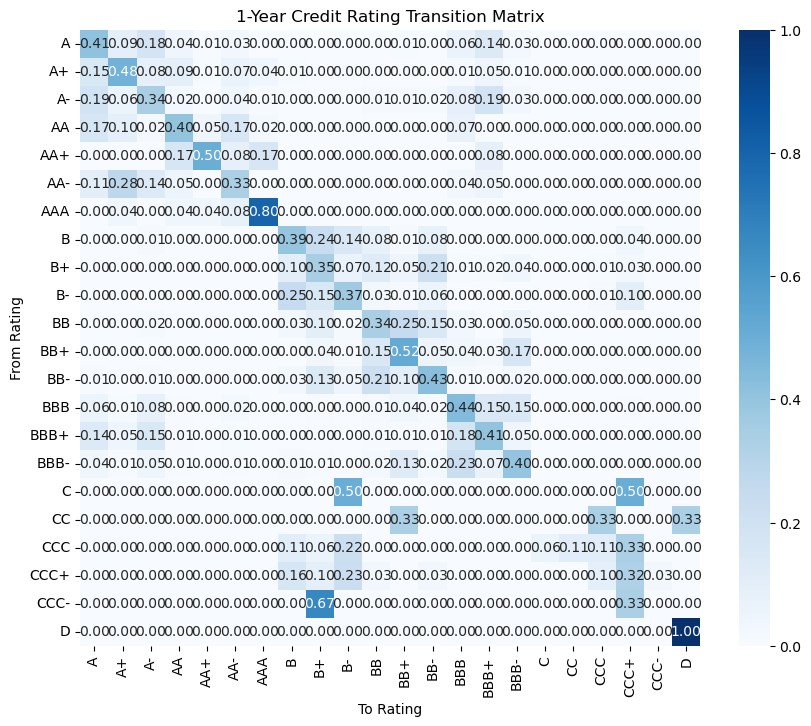

In [35]:
# Transition Matrix 
import matplotlib.pyplot as plt
import seaborn as sns

# Show transition matrix as DataFrame
print("1-Year Transition Matrix:")
display(P.round(3))  # nicely formatted table in Jupyter

# Heatmap plot
plt.figure(figsize=(10,8))
sns.heatmap(P, annot=True, fmt=".2f", cmap="Blues")
plt.title("1-Year Credit Rating Transition Matrix")
plt.ylabel("From Rating")
plt.xlabel("To Rating")
plt.show()


In [13]:
counts.to_csv("transition_counts.csv")
P.to_csv("transition_matrix_1yr.csv")


In [15]:
#Step C — multi-year (P^k) and default curves
import numpy as np
Pmat = P.fillna(0).values
def matrix_power(Pmat, k):
    return np.linalg.matrix_power(Pmat, k)

# compute 1..5 year matrices
multi = {k: pd.DataFrame(np.linalg.matrix_power(Pmat,k), index=ratings, columns=ratings) for k in range(1,6)}
# example: 5-year default probs
five_year_defaults = multi[5]['D']   # if 'D' is default label
five_year_defaults.to_csv("5yr_default_probs.csv")


5-Year Default Probabilities:


A       0.0000
A+      0.0000
A-      0.0000
AA      0.0000
AA+     0.0000
AA-     0.0000
AAA     0.0000
B       0.0007
B+      0.0008
B-      0.0018
BB      0.0001
BB+     0.0001
BB-     0.0002
BBB     0.0000
BBB+    0.0000
BBB-    0.0000
C       0.0033
CC      0.3481
CCC     0.0457
CCC+    0.0064
CCC-    0.0022
D       1.0000
Name: D, dtype: float64

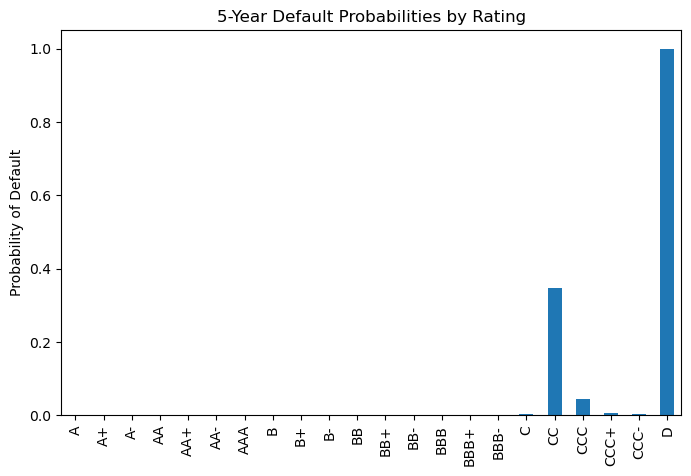

In [37]:
# 5-Year Default Probabilities 
# Display 5-year default probabilities
print("5-Year Default Probabilities:")
display(multi[5]['D'].round(4))  # assumes 'D' is default

# Plot
plt.figure(figsize=(8,5))
multi[5]['D'].plot(kind='bar')
plt.title("5-Year Default Probabilities by Rating")
plt.ylabel("Probability of Default")
plt.show()


In [17]:
#Step D — Bayesian posterior (Dirichlet conjugate sampling) — quick & robust
n_samples = 5000
post_samples = {}
ci_default = {}
if 'D' in ratings:
    j = ratings.index('D')
for i, r in enumerate(ratings):
    row_counts = counts.loc[r].values if r in counts.index else np.zeros(len(ratings),dtype=int)
    alpha_post = row_counts + 1   # uniform prior alpha=1
    S = np.random.dirichlet(alpha_post, size=n_samples)  # samples of that row
    post_samples[r] = S
    if 'D' in ratings:
        ds = S[:, j]
        ci_default[r] = (ds.mean(), np.percentile(ds,2.5), np.percentile(ds,97.5))
# export CI table for report
pd.DataFrame.from_dict({r: {'mean':v[0],'2.5%':v[1],'97.5%':v[2]} for r,v in ci_default.items()}, orient='index')\
  .to_csv("1yr_default_credible_intervals.csv")


Posterior Credible Intervals for 1-Year Default Probabilities:


,mean,2.5%,97.5%
A,0.0049,0.0001,0.0183
A+,0.0080,0.0002,0.0293
A-,0.0053,0.0001,0.0196
AA,0.0157,0.0004,0.0555
AA+,0.0301,0.0008,0.1074
AA-,0.0129,0.0003,0.0480
AAA,0.0216,0.0005,0.0791
B,0.0101,0.0003,0.0370
B+,0.0073,0.0002,0.0260
B-,0.0113,0.0002,0.0391


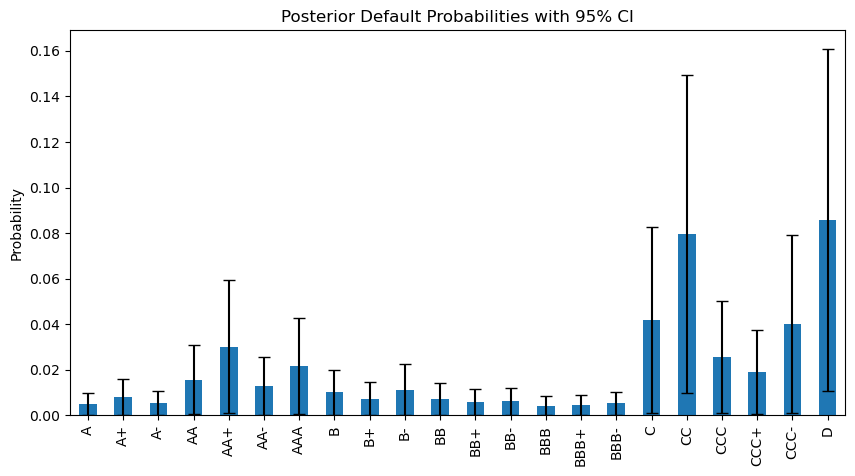

In [39]:
# Posterior Credible Intervals 
ci_df = pd.DataFrame.from_dict(
    {r: {'mean':v[0], '2.5%':v[1], '97.5%':v[2]} for r,v in ci_default.items()},
    orient='index'
).round(4)

print("Posterior Credible Intervals for 1-Year Default Probabilities:")
display(ci_df)

# Plot
ci_df[['mean']].plot(kind='bar', yerr=[ci_df['mean']-ci_df['2.5%'], ci_df['97.5%']-ci_df['mean']], 
                     legend=False, figsize=(10,5), capsize=4)
plt.title("Posterior Default Probabilities with 95% CI")
plt.ylabel("Probability")
plt.show()


In [19]:
#Step E — stationary distribution
eigvals, eigvecs = np.linalg.eig(Pmat.T)
idx = np.argmin(np.abs(eigvals - 1.0))
pi = np.real(eigvecs[:,idx])
pi = pi / pi.sum()
pd.Series(pi, index=ratings).to_csv("stationary_distribution.csv")


Stationary Distribution of Ratings:


A       0.0
A+      0.0
A-      0.0
AA      0.0
AA+     0.0
AA-     0.0
AAA     0.0
B       0.0
B+      0.0
B-      0.0
BB      0.0
BB+     0.0
BB-     0.0
BBB     0.0
BBB+    0.0
BBB-    0.0
C       0.0
CC      0.0
CCC     0.0
CCC+    0.0
CCC-    0.0
D       1.0
dtype: float64

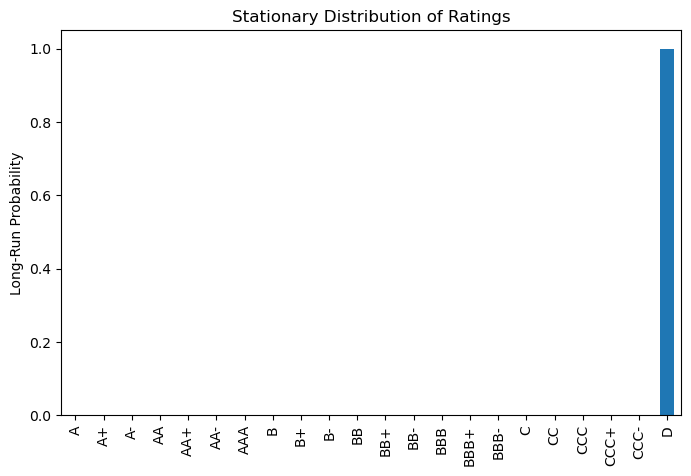

In [41]:
# Stationary Distribution 
pi_series = pd.Series(pi, index=ratings).round(4)

print("Stationary Distribution of Ratings:")
display(pi_series)

# Bar plot
plt.figure(figsize=(8,5))
pi_series.plot(kind='bar')
plt.title("Stationary Distribution of Ratings")
plt.ylabel("Long-Run Probability")
plt.show()


In [21]:
#Step F — simulate rating paths 
def simulate_path(start_rating, Pmat, ratings, horizon=10):
    idx = ratings.index(start_rating)
    path = [start_rating]
    cur = idx
    for t in range(horizon):
        cur = np.random.choice(len(ratings), p=Pmat[cur])
        path.append(ratings[cur])
    return path
# simulate many paths using posterior sampled P rows (use full sampled matrix assembly if desired)


In [25]:
#Drop duplicate rating from snap
snap = df.sort_values(['firm_id','Rating Date']).groupby(['firm_id','Year']).last().reset_index()
snap = snap[['firm_id','Year'] + fin_cols]   # drop Rating column


In [27]:
#Merge
train = pd.merge(merged, snap, left_on=['firm_id','Year_t'], right_on=['firm_id','Year'], how='left')


In [29]:
# Rename snap
snap = snap.rename(columns={'Rating_t': 'Rating_snapshot'})


In [31]:
#Step G — link transitions to financial ratios (predict next-year rating)
# financial snapshot without rating
snap = df.sort_values(['firm_id','Rating Date']).groupby(['firm_id','Year']).last().reset_index()
snap = snap[['firm_id','Year'] + fin_cols]

# merge with transitions
train = pd.merge(merged, snap, left_on=['firm_id','Year_t'], right_on=['firm_id','Year'], how='left')

# Encode and fit model
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

le = LabelEncoder()
y = le.fit_transform(train['Rating_t1'].astype(str))

X = pd.DataFrame()
X['rating_code'] = LabelEncoder().fit_transform(train['Rating_t'].astype(str))  # from merged
for c in fin_cols:
    X[c] = train[c].fillna(train[c].median())

clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
clf.fit(X, y)


C:\Users\sagni\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [33]:
#ConvergenceWarning just means your model hit the max_iter=1000 cap
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
clf.fit(X_scaled, y)


LogisticRegression(max_iter=1000, multi_class='multinomial')